# Churn Model: Data exploration
In this notebook, we explore the dataset to familiarize with its content and understand the key features that may influence customer churn. We will check for missing values, analyze feature distributions, and look for patterns or correlations that could help predict churn effectively.

### Table of contents:
1. Initial Analysis
2. Numerical & Categorical Analysis
- Feature Distribution Analysis
- Correlation Analysis
- Categorical Feature-Target Relationship

In [2]:
import math

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns

from pandas.api.types import is_numeric_dtype
from scipy.stats import chi2_contingency

# Initial Analysis

We start by displaying the data, and gather information about the dtypes, missing values, percentiles, unique values and duplicate rows. 

In [3]:
raw_df = pd.read_excel("../data/data.xlsx")
raw_df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001.0,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002.0,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003.0,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004.0,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005.0,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [4]:
# Typo correction
raw_df.rename(columns={"PreferedOrderCat": "PreferredOrderCat"}, inplace=True)
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5628 non-null   float64
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5628 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferredOrderCat            5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

In [5]:
raw_df.describe(percentiles=[0.01, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,95%,99%,max
CustomerID,5628.0,52814.549041,1624.890759,50001.0,50057.27,50563.70,51407.75,52814.50,54221.2500,55065.30,55346.6500,55573.7300,55630.0
Churn,5630.0,0.168384,0.374240,0.0,0.00,0.00,0.00,0.00,0.0000,1.00,1.0000,1.0000,1.0
Tenure,5366.0,10.189899,8.557241,0.0,0.00,1.00,2.00,9.00,16.0000,23.00,27.0000,30.0000,61.0
CityTier,5630.0,1.654707,0.915389,1.0,1.00,1.00,1.00,1.00,3.0000,3.00,3.0000,3.0000,3.0
WarehouseToHome,5379.0,15.639896,8.531475,5.0,6.00,7.00,9.00,14.00,20.0000,30.00,33.0000,35.0000,127.0
HourSpendOnApp,5375.0,2.931535,0.721926,0.0,2.00,2.00,2.00,3.00,3.0000,4.00,4.0000,4.0000,5.0
NumberOfDeviceRegistered,5630.0,3.688988,1.023999,1.0,1.00,3.00,3.00,4.00,4.0000,5.00,5.0000,6.0000,6.0
SatisfactionScore,5630.0,3.066785,1.380194,1.0,1.00,1.00,2.00,3.00,4.0000,5.00,5.0000,5.0000,5.0
NumberOfAddress,5630.0,4.214032,2.583586,1.0,1.00,2.00,2.00,3.00,6.0000,8.00,10.0000,11.0000,22.0
Complain,5630.0,0.284902,0.451408,0.0,0.00,0.00,0.00,0.00,1.0000,1.00,1.0000,1.0000,1.0


In [6]:
raw_df["CustomerID"].nunique()

5628

<Axes: >

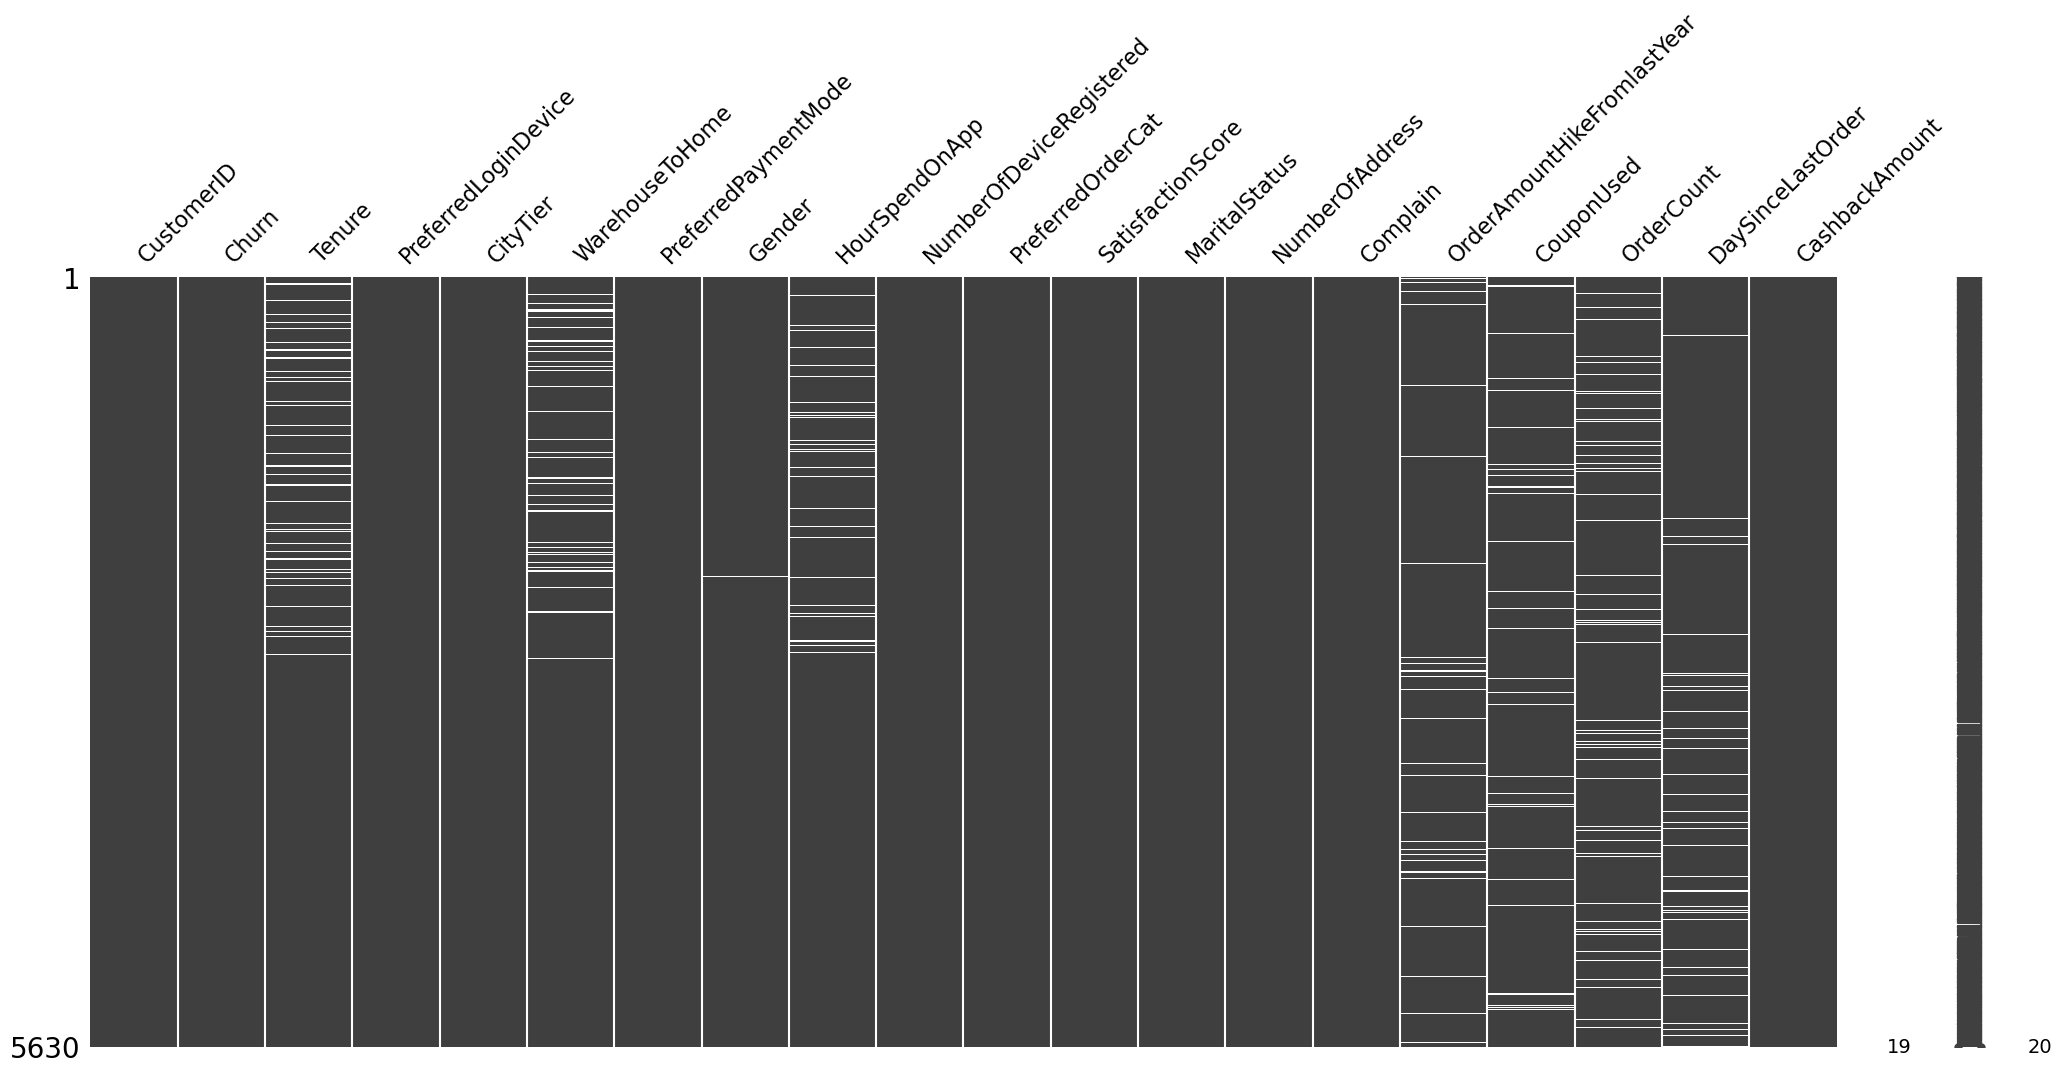

In [7]:
msno.matrix(raw_df)

In [8]:
raw_df.isna().sum(), raw_df.isna().sum().sum() # Per feature, total

(CustomerID                       2
 Churn                            0
 Tenure                         264
 PreferredLoginDevice             0
 CityTier                         0
 WarehouseToHome                251
 PreferredPaymentMode             0
 Gender                           2
 HourSpendOnApp                 255
 NumberOfDeviceRegistered         0
 PreferredOrderCat                0
 SatisfactionScore                0
 MaritalStatus                    0
 NumberOfAddress                  0
 Complain                         0
 OrderAmountHikeFromlastYear    265
 CouponUsed                     256
 OrderCount                     258
 DaySinceLastOrder              307
 CashbackAmount                   0
 dtype: int64,
 np.int64(1860))

In [9]:
# CustomerID and Churn are neither numerical or categorical
# The former is a identifier, the latter is the output label

numerical_columns = ["Tenure", "WarehouseToHome", "HourSpendOnApp", 
                     "NumberOfDeviceRegistered", "SatisfactionScore", 
                     "NumberOfAddress", "OrderAmountHikeFromlastYear", 
                     "CouponUsed", "OrderCount", "DaySinceLastOrder",
                     "CashbackAmount"]

categorical_columns = ["PreferredLoginDevice", "CityTier", 
                       "PreferredPaymentMode", "Gender", "PreferredOrderCat",
                       "MaritalStatus", "Complain", "Churn"]

In [10]:
def print_unique(df):
    """
        Print the unique values found in the dataframe.
    """
    for column in df:
        print(f"{column} -> {df[column].unique()}")

print_unique(raw_df[categorical_columns])

PreferredLoginDevice -> ['Mobile Phone' 'Phone' 'Computer' 'N.A.']
CityTier -> [3 1 2]
PreferredPaymentMode -> ['Debit Card' 'UPI' 'CC' 'Cash on Delivery' 'E wallet' 'COD' 'Credit Card']
Gender -> ['Female' 'Male' nan]
PreferredOrderCat -> ['Laptop & Accessory' 'Mobile' 'Mobile Phone' 'Others' 'Fashion' 'Grocery']
MaritalStatus -> ['Single' 'Divorced' 'Married' 'Widow']
Complain -> [1 0]
Churn -> [1 0]


Here we make our **first change**. 'N.A.' in `PreferredLoginDevice` should be instead 'Other'. Also, `Mobile` should be merged with `Mobile Phone`. `CC` should represent `Credit Card`, as `COD` represents `Cash On Delivery`.

In [11]:
clean_df = raw_df.copy()
clean_df['PreferredLoginDevice'] = clean_df['PreferredLoginDevice'].replace('N.A.', 'Other')
clean_df['PreferredOrderCat'] = clean_df['PreferredOrderCat'].replace('Mobile Phone', 'Mobile')
clean_df['PreferredPaymentMode'] = clean_df['PreferredPaymentMode'].replace({
    'CC': 'Credit Card',
    'COD': 'Cash on Delivery'
})

# Numerical and Categorical Analysis

We divide the dataframe into two distinct types: those with a continuous value, and those with discrete categories. 

We plot their distributions, voice our expectations on the feature's discriminative power, and their correlations. 

### Feature Distribution Analysis

We visualize the distribution of each feature, separated by the churn target. This helps us understand how each variable differs between churned and non-churned customers, and spot potential outliers or skewed distributions.

[>] Initializing 7 x 3 subplots for 19 columns...


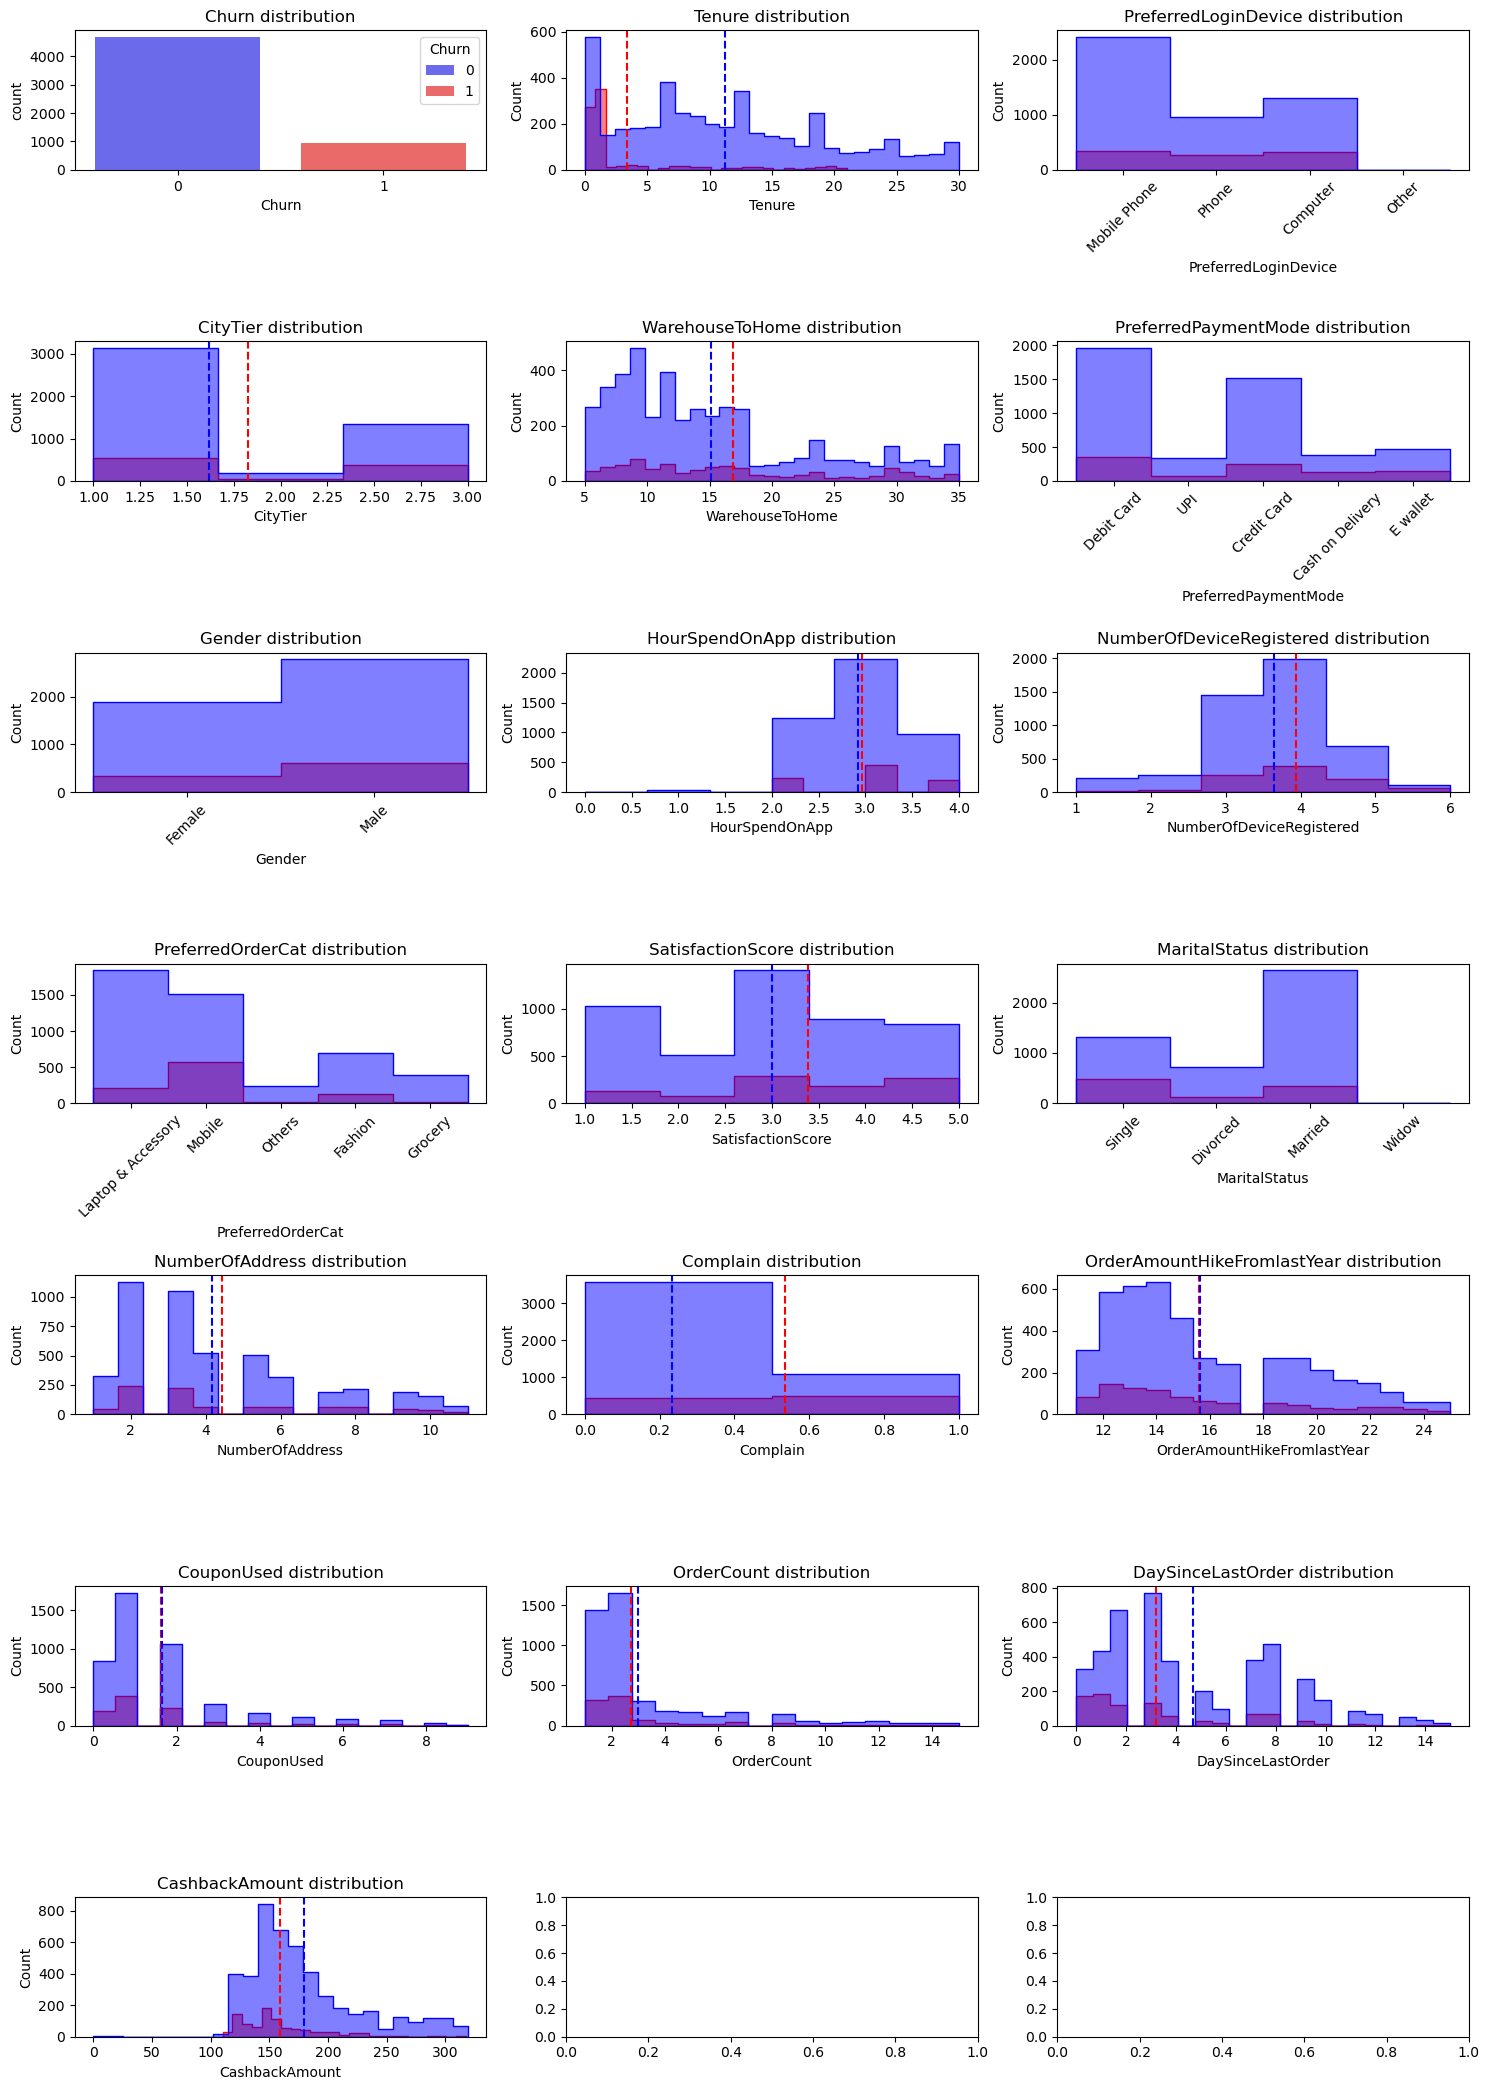

In [12]:
def plot_distributions(df, target : str, *, ignore_cols=[], percentile=None):
    """
        Plot overlapping distributions of a dataframe, separated by a binary target. 

        Parameters
        ----------
        df : pandas.Dataframe
            The dataframe with the data to plot.

        target : str
            The name of the target variable column.

        ignore_cols : list, optional 
            Columns to ignore in the plot (default is []).

        percentile : float, optional
            Ignore outliers given a percentile value between 0 and 1 (default is None).
        
    """

    df = df.copy()
    df = df.drop(columns=ignore_cols)
    num_columns = len(df.columns)

    # Compute number of rows in the subplots
    subplot_rows = math.ceil(num_columns / 3)
    print(f"[>] Initializing {subplot_rows} x 3 subplots for {num_columns} columns...")
    fig, ax = plt.subplots(subplot_rows, 3, figsize=(15, 3 * subplot_rows))
    i = 0 # Row position
    j = 0 # Column position

    for column in df.columns:

        ax[i, j].set_title(f"{column} distribution")
        if column == target:
            sns.countplot(x=df[target], hue=df[target], palette='seismic', ax=ax[i, j])
            if j < 2:
                j += 1
            else:
                j = 0
                i += 1
            continue

        # Filter extreme outliers
        if percentile and df[column].dtype != pd.StringDtype:
            perc = df[column].quantile(percentile)
            true_mask = (df[target] == 1) & (df[column] <= perc)
            false_mask = (df[target] == 0) & (df[column] <= perc)
        else: 
            true_mask = (df[target] == 1)
            false_mask = (df[target] == 0)

        true_col_vals = df[column][true_mask]
        false_col_vals = df[column][false_mask]

        # Compute bins
        n_unique = df[column].nunique()
        bins = 25 if n_unique > 25 else n_unique

        if is_numeric_dtype(true_col_vals): # Numerical 
            mean_true = true_col_vals.mean()
            mean_false = false_col_vals.mean()
            ax[i, j].axvline(mean_true, color='red', linestyle='--')
            ax[i, j].axvline(mean_false, color='blue', linestyle='--')
        else: # Categorical
            ax[i, j].tick_params(axis='x', labelrotation=45)

        sns.histplot(true_col_vals, bins=bins, element='step', alpha=0.5, color='red', ax=ax[i, j])
        sns.histplot(false_col_vals, bins=bins, element='step', alpha=0.5, color='blue', ax=ax[i, j])

        if j < 2:
            j += 1
        else:
            j = 0
            i += 1

    plt.tight_layout()
    plt.show()

plot_distributions(clean_df, 'Churn', ignore_cols=['CustomerID'], percentile=0.99)



We have some data on how each feature is distributed. Here's a brief description for each feature:

### Numerical

**Tenure (exp. relevancy: high)**

- Longer tenure = lower churn risk. We have many customers whose tenure is low, but those with high tenure are also non irrelevant. 

**WarehouseToHome (exp. relevancy: situational)**

- Distance might impact customer satisfaction, depending on what the unit distance means. A few outliers have very large distances.

**HourSpentOnApp (exp. relevancy: high)**

- Engagement level is a stong churn indicator. Most of the customers spend from 2 to 4 hours.

**NumberOfDeviceRegistered (exp. relevancy: unknown)**

- May indicate account sharing. If so, to be considered a churned customer, shouldn't all members sharing the account churn?

**SatisfactionScore (exp. relevancy: high)**

- Direct measure of user happiness. Mainly concentrated around 3, with almost equal parts of satisfied and dissatisfied users. 

**NumberOfAddress (exp. relevancy: unknown)**

- Are the addresses added automatically by the system, or the user needs to manually add them? Most of them are centered around 1 and 2.

**OrderAmountHikeFromlastYear (exp. relevancy: high)**

- Increasing spending implies royalty. But in our data, we do not have decrease.

**CouponUsed (exp. relevancy: situational)**

- Indicates promotional dependence. Most of the customers used 0 to 3 coupons in the last month.

**OrderCount (exp. relevancy: high)**

- More frequent orders indicates user activity and royalty.

**DaySinceLastOrder (exp. relevancy: high)**

- Longer gaps indicates risk of churn. Most are within 10 days since the last order. 

**CashbackAmount (exp. relevancy: situational)**

- Indicates promotional dependence. 

### Categorical

**PreferredLoginDevice (exp. relevancy: low)**

- This might show user habits. Mobile phone is the preferred way.

**CityTier (exp. relevancy: high)**

- Economic and service differences by city tier can affect churn. Many customers live in tier 1 and tier 3 cities.

**PreferredPaymentMode (exp. relevancy: low)**

- Preferred payment mode relate to user convenience or issues (think if electronic payment fails). Still, we expect it not to be that predictive.

**GenderDistribution (exp. relevancy: low)**

- Usually minimal direct effect on churn unless tied to marketing differences.

**PreferredOrderCat (exp. relevancy: unknown)**

- It might be linked to churn risk, but more than anything it indicates user preferences rather than dissatisfaction.

**MaritalStatus (exp. relevancy: low)**

- Not really sure how the marital status might affect churn risk.

**Complain (exp. relevancy: high)**

- Complaints often predict churn directly.


### Handling Missing Values

To ensure robust analysis, we impute missing values: numerical columns use mean imputation, while categorical columns use mode imputation.

During model training, we will combine all preprocessing steps in a pipeline: This time is just for data analysis.

In [13]:
clean_df[numerical_columns] = clean_df[numerical_columns].fillna(clean_df[numerical_columns].mean()) # Mean Imputation
clean_df[categorical_columns] = clean_df[categorical_columns].fillna(clean_df[categorical_columns].mode().iloc[0]) # Mode Imputation

numerical_df = clean_df[numerical_columns]
categorical_df = clean_df[categorical_columns]

## Correlation Analysis

We compute and visualize the Pearson correlation matrix for numerical features (including the target). This helps identify which features are most strongly associated with churn and with each other.

Additionally we plot Churn-Feature graphs to see how each of them linearly influence our target variable.

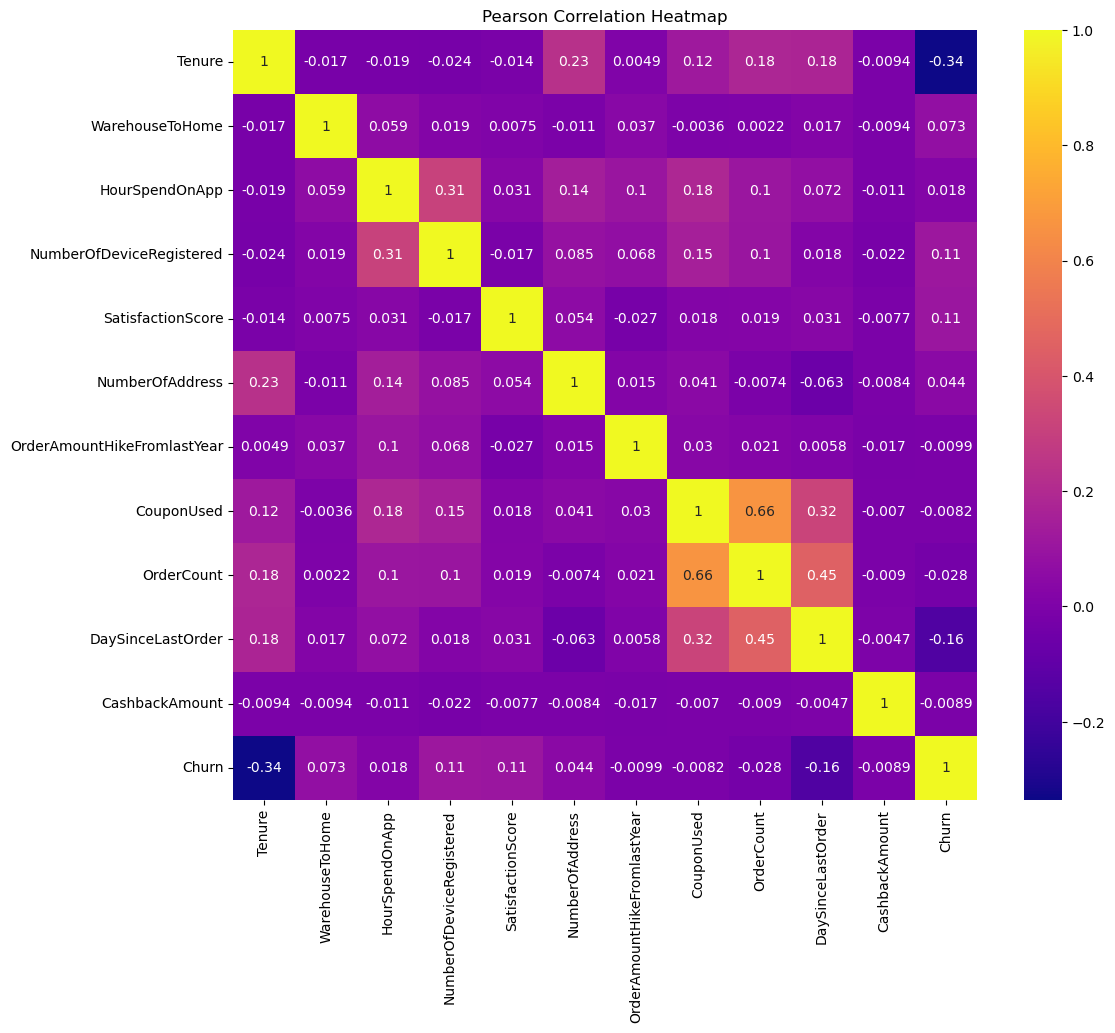

In [14]:
corr = clean_df[numerical_columns + ['Churn']].corr()

plt.figure(figsize=(12, 10))
plt.title("Pearson Correlation Heatmap")
sns.heatmap(corr, cmap='plasma', annot=True)
plt.show()

[>] Initializing 4 x 3 subplots for 11 columns...


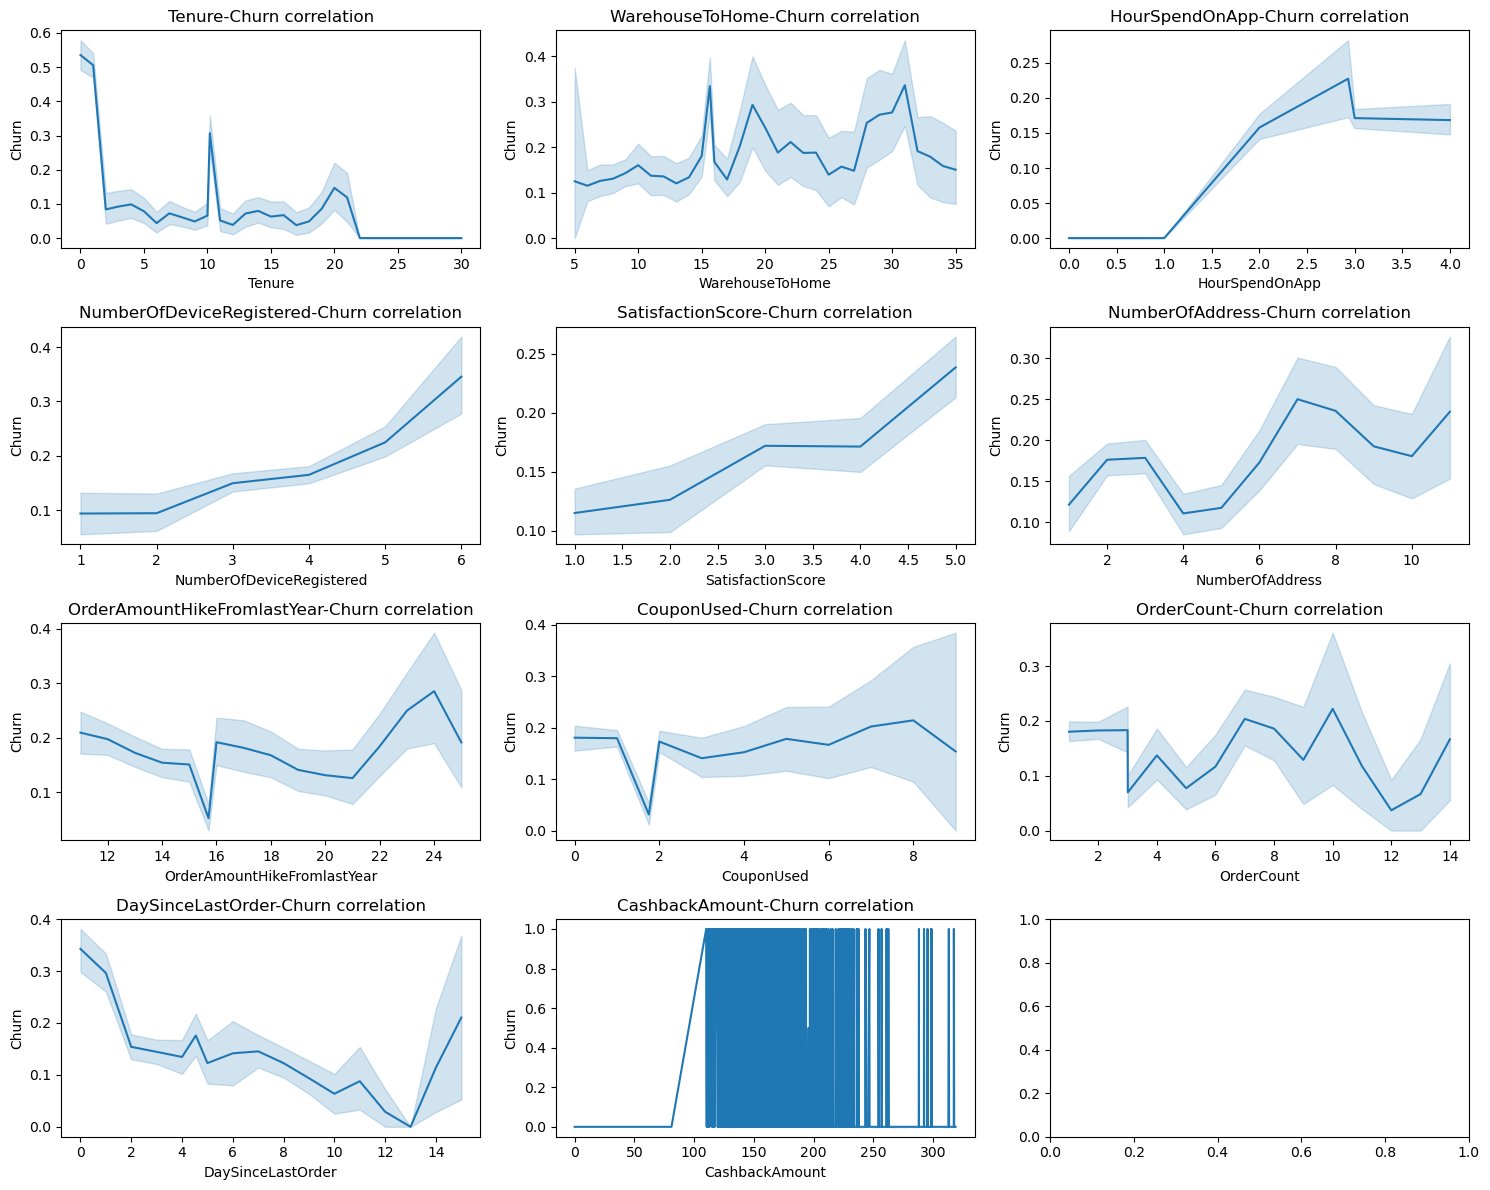

In [15]:
def plot_target_correlation(df, target, *, percentile=None):
    """
        Plot for each feature their correlation with a target variable in dataframe.

        Parameters
        ----------
        df : pandas.Dataframe
            The dataframe with the data to plot.

        target : str
            The name of the target variable column.

        percentile : float, optional
            Ignore outliers given a percentile value between 0 and 1 (default is None).
        
    """
    df = df.copy()
    df = df[numerical_columns + [target]]
    num_columns = len(df.columns) - 1
    subplot_rows = math.ceil(num_columns / 3)
    print(f"[>] Initializing {subplot_rows} x 3 subplots for {num_columns} columns...")
    fig, ax = plt.subplots(subplot_rows, 3, figsize=(15, 3 * subplot_rows))
    i = 0
    j = 0

    for column in df.columns: 
        if column == target:
            continue

        if percentile:
            perc = df[column].quantile(percentile)
            perc_mask = df[column] <= perc
            temp_df = df[[column, target]][perc_mask]
        else:
            temp_df = df[[column, target]]
        
        ax[i, j].set_title(f"{column}-{target} correlation")
        sns.lineplot(x=column, y=target, data=temp_df, estimator='mean', ax=ax[i, j])

        if j < 2:
            j += 1
        else:
            j = 0
            i += 1

    
    plt.tight_layout()
    plt.show()


plot_target_correlation(clean_df, 'Churn', percentile=0.99)

The most influencing factors were, without much surprise, `Tenure` and `DaySinceLastOrder`. What is instearesting is instead how `NumberOfDeviceRegistered` is more influencing than `SatisfactionScore`. Not only that, but more devices does not mean less churn rate. We hypothetized that high number of devices = shared account -> all must stop making orders to be considered churned. Instead, here we have the opposite case.

`OrderCount` and `OrderAmountHikeFromLastYear` are also surprising ones, since they have small influence over `Churn`.

What is crazy instead is the sign of `SatisfactionScore`: higher score leads to higher churn rate (at least linearly).

## Categorical Feature-Target Relationships

Let's see how categorical values affect churn rate. We can perform Cramér's V, and plot the values in a heatmap matrix.

Note: Since it is based on Chi-squared, the values in the matrix will always be positive. This is a measure of association strength, since it is not reasonable to expect order or distance between categories.

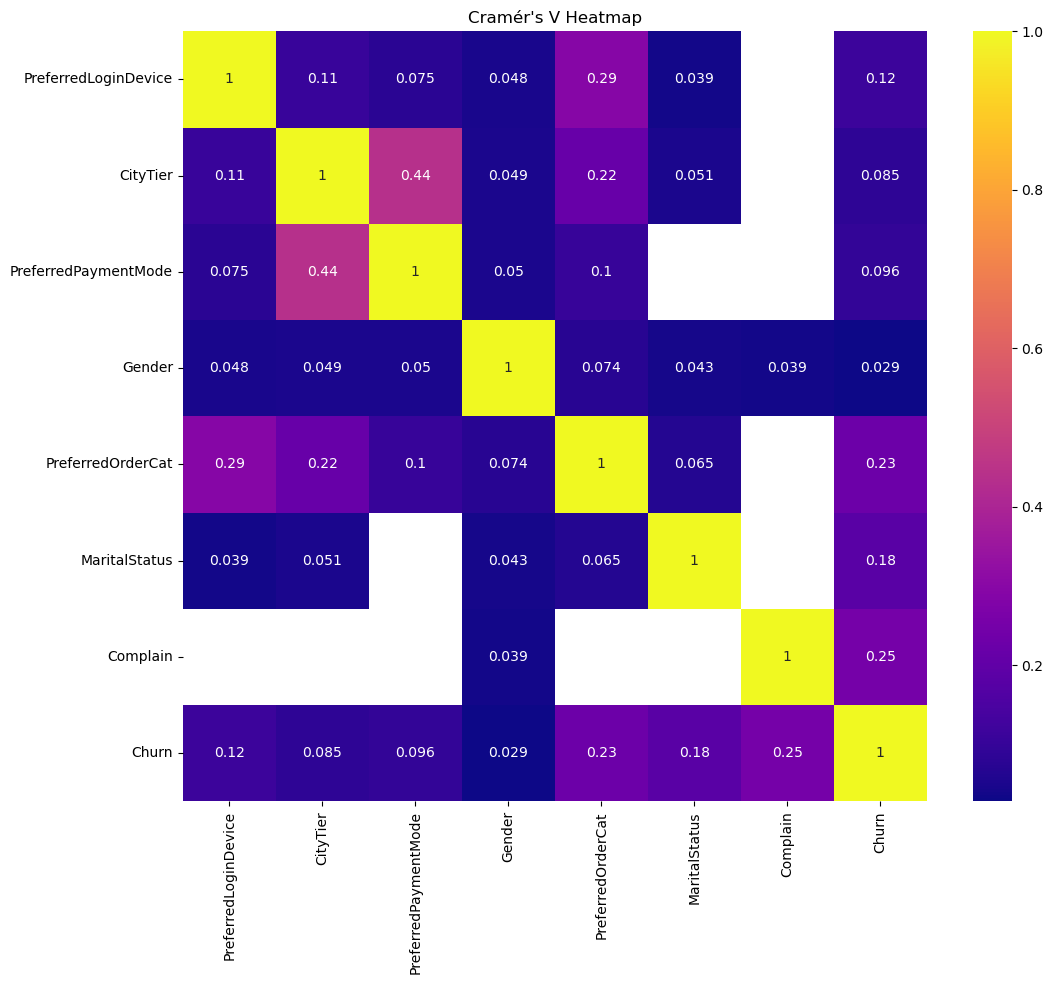

In [16]:
def cramers_v(x, y, alpha : float):
    """
        Compute the Cramér's V of two categorical values.

        Parameters
        ----------
        x : iterable
            The first categorical value iterable.

        y : iterable
            The second categorical value iterable.

        alpha : float
            Alpha value to test the resulting p-value against.
            P-value >= `alpha` are ignored.

        Returns
        -------
        float
            The Cramér's V measure. Returns `nan` if p-value is greater or equal than `alpha`.
        
    """
    confusion_matrix = pd.crosstab(x, y)
    chi2, p, _, _ = chi2_contingency(confusion_matrix)
    if p >= alpha:
        return np.nan # Remove p >= alpha: non significant
    n = confusion_matrix.sum().sum()
    k = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * k))

corr_matrix = pd.DataFrame(
    np.zeros((len(categorical_columns), len(categorical_columns))),
    index=categorical_columns,
    columns=categorical_columns
)

for col1 in categorical_columns:
    for col2 in categorical_columns:
        corr_matrix.loc[col1, col2] = cramers_v(categorical_df[col1], categorical_df[col2], alpha=0.05)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='plasma')
plt.title("Cramér's V Heatmap")
plt.show()

`CityTier`, understandably, is linked to `PreferredPaymentMode`. Other than that, `PreferredLoginDevice` and `PreferredPaymentMode` have positive strength association with `PreferredOrderCat`. Evidently, if you were to buy a 2000$ computer, let's say, you may not walk around with that much amount of cash, and prefer card payments. 

Now, for the interesting point: `Churn` has a slightly stronger association with Complain, and surprisingly `PreferredOrderCat` and `MaritalStatus`. While the association strength is quite low in general, these three are the most linked to the churn rates, and can be considered moderate level of strength. 

The question that arises is: *What categories of order are the most likely to churn? What was they tenure along with the order count?*

In [17]:
true_mask = (clean_df['Churn'] == 1)
clean_df[['PreferredOrderCat', 'Tenure', 'OrderCount']][true_mask].value_counts()

PreferredOrderCat   Tenure     OrderCount
Mobile              1.000000   2.0           191
                    0.000000   1.0           129
                    10.189899  1.0            68
Laptop & Accessory  1.000000   2.0            40
                    0.000000   1.0            40
                                            ... 
Others              16.000000  7.0             2
                    20.000000  13.0            2
                    21.000000  14.0            2
Laptop & Accessory  12.000000  1.0             1
                    13.000000  2.0             1
Name: count, Length: 148, dtype: int64

Conclusion: If the system considers every buyer to be expected to return, then one-time buyers are the most populated among the churned customers. Indeed, many customers buyed a phone or a laptop 1 or 2 times, and then stopped coming. Also, tenure was quite low, between 0 and 1.

In [18]:
clean_df.to_excel("../data/clean_data.xlsx")